In [1]:
from deap import tools, base, creator

import random, array

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0, "C:/Jupyter/Evolution")
import elitysm

import math

In [2]:
DIMENSIONS = 2
BOUND_LOW, BOUND_UP = -5.0, 5.0

POPULATION_SIZE = 300
P_CROSSOVER = 0.9
P_MUTATION = 0.1
MAX_GENERATIONS = 300
HALL_OF_FAME_SIZE = 30
GROWDING_FACTOR = 20.0

DISTANCE_THRESHOLD = 0.1
SHARING_EXTENT = 5.0

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [3]:
def randomFloat(low, up):
    return [random.uniform(a, b) for a, b in zip([low] * DIMENSIONS, [up] * DIMENSIONS)]

In [4]:
toolbox = base.Toolbox()

creator.create("FitnessMax", base.Fitness, weights = (1.0,))

creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox.register("attr_float", randomFloat, BOUND_LOW, BOUND_UP)
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [5]:
def himmelblauInverted(individual):
    x= individual[0]
    y= individual[1]
    f=((x**2+y-11)**2)+((x+y**2-7)**2)
    return 2000.0-f,

toolbox.register("evaluate", himmelblauInverted)

In [10]:
toolbox.register("select", selTournamentWithSharing, tournsize = 2)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low = BOUND_LOW, up = BOUND_UP, eta = GROWDING_FACTOR)
toolbox.register("mutate", tools.mutPolynomialBounded, low = BOUND_LOW, up = BOUND_UP, eta = GROWDING_FACTOR, indpb= 1.0/DIMENSIONS)

In [7]:
def selTournamentWithSharing(individuals, k, tournsize, fit_attr="fitness"):

    # get orig fitnesses:
    origFitnesses = [ind.fitness.values[0] for ind in individuals]

    # apply sharing to each individual:
    for i in range(len(individuals)):
        sharingSum = 1

        # iterate over all other individuals
        for j in range(len(individuals)):
            if i != j:
                # calculate eucledean distance between individuals:
                distance = math.sqrt(
                    ((individuals[i][0] - individuals[j][0]) ** 2) + ((individuals[i][1] - individuals[j][1]) ** 2))

                if distance < DISTANCE_THRESHOLD:
                    sharingSum += (1 - distance / (SHARING_EXTENT * DISTANCE_THRESHOLD))

        # reduce fitness accordingly:
        individuals[i].fitness.values = origFitnesses[i] / sharingSum,

    # apply original tools.selTournament() using modified fitness:
    selected = tools.selTournament(individuals, k, tournsize, fit_attr)

    # retrieve original fitness:
    for i, ind in enumerate(individuals):
        ind.fitness.values = origFitnesses[i],

    return selected

In [15]:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with elitism:
    population, logbook = elitysm.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])

    print("- Best solutions are:")
    for i in range(HALL_OF_FAME_SIZE):
        print(i, ": ", hof.items[i].fitness.values[0], " -> ", hof.items[i])

    # plot solution locations on x-y plane:
    plt.figure(1)
    globalMaxima = [[3.0, 2.0], [-2.805118, 3.131312], [-3.779310, -3.283186], [3.584458, -1.848126]]
    plt.scatter(*zip(*globalMaxima), marker='x', color='red', zorder=1)
    plt.scatter(*zip(*population), marker='.', color='blue', zorder=0)    # plot solution locations on x-y plane:

    # plot best solutions locations on x-y plane:
    plt.figure(2)
    plt.scatter(*zip(*globalMaxima), marker='x', color='red', zorder=1)
    plt.scatter(*zip(*hof.items), marker='.', color='blue', zorder=0)

    # extract statistics:
    maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

    # plot statistics:
    plt.figure(3)
    sns.set_style("whitegrid")
    plt.plot(maxFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Max / Average Fitness')
    plt.title('Max and Average fitness over Generations')

    plt.show()

gen	nevals	max    	avg    
0  	300   	1999.72	1875.45
1  	247   	1999.89	1916.3 
2  	232   	1999.89	1932.67
3  	240   	1999.89	1941.9 
4  	243   	1999.96	1949.86
5  	247   	1999.96	1954.23
6  	242   	1999.96	1955.29
7  	239   	1999.96	1955.01
8  	252   	1999.96	1951.27
9  	258   	1999.96	1948.85
10 	246   	1999.96	1956.79
11 	239   	1999.96	1950.26
12 	247   	1999.96	1955.39
13 	249   	1999.97	1958.63
14 	254   	1999.97	1959.54
15 	240   	1999.97	1961.52
16 	252   	1999.97	1960.35
17 	250   	1999.97	1960.87
18 	244   	1999.99	1956.65
19 	245   	1999.99	1958.39
20 	250   	1999.99	1959.63
21 	260   	1999.99	1959.19
22 	250   	1999.99	1953.69
23 	240   	1999.99	1952.27
24 	235   	1999.99	1957.09
25 	240   	1999.99	1962.01
26 	234   	1999.99	1960.02
27 	254   	1999.99	1954.42
28 	245   	1999.99	1952.38
29 	241   	1999.99	1946.78
30 	244   	1999.99	1947.86
31 	250   	1999.99	1950.59
32 	235   	1999.99	1958.15
33 	259   	1999.99	1958.99
34 	247   	1999.99	1959.77
35 	243   	1999.99	1958.44
3

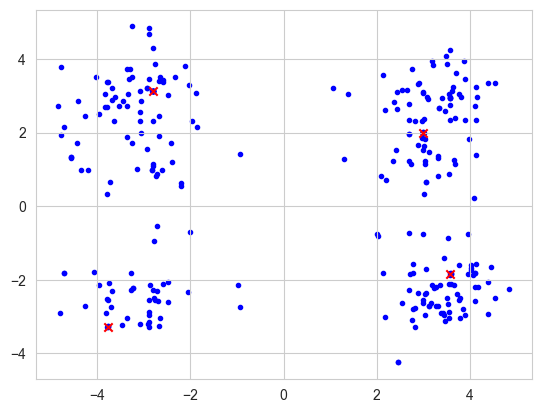

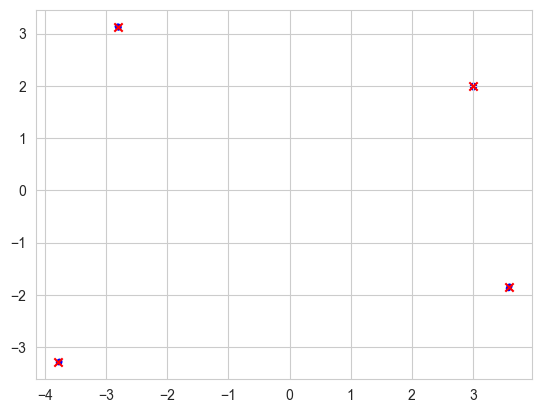

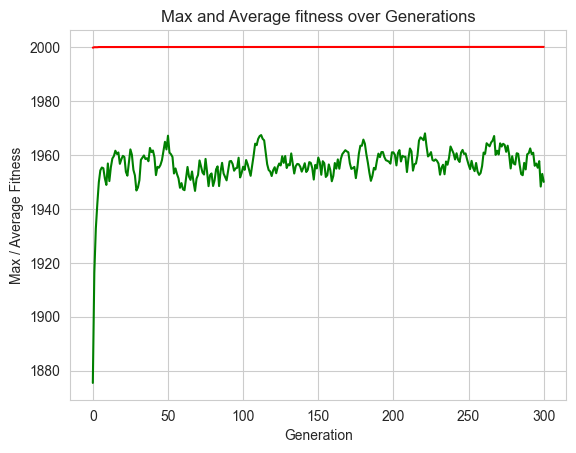

In [16]:
main()